### **ECON 323 FINAL PROJECT**

### **PARLIAMENTARY PARTICIPATION AND ELECTORAL SUCCESS**

##### INTRODUCTION

In this project, we aim to create a visualization notebook based on a ECON 490 paper. The paper explores the impact of parliamentary participation on electoral success particularly in the Canadian House of Commons. 

In this case, parliamentary participation is measured by participation in question period and statements made in the House of Commons and the private member bills introduced by the Member of Parliament. Electoral success is measured by whether or not the Member of Parliament was reelected in the next federal elections.

For this project, we will create a visualization notebook that focuses on:
- visually summarizing the variables 
- exploring relationships between the independent and dependent variables 

##### LOADING PACKAGES

We start by loading all the necessary packages:

In [100]:
import pandas as pd
import numpy as np
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import sklearn
import sklearn.model_selection
import sklearn.ensemble
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

%matplotlib inline

##### INTRODUCING THE DATA 

##### *Reading the Data*

We will first load in the data from csv files and rename columns so that the two dataframes can be concatenated.

The data in the csv files has been compiled from several sources:
- Elections Canada for reelection and riding information
- OurCommons website for information on Private Member's Bills, statements made and Cabinet ministers
- SQL Database from the openparliament.com website for gender, party and politician name
- Conservative.ca website for information on Shadow Cabinet
- Age and years in House of Commons from Parl.ca website 

The timeframe for this data is from the 2015 federal elections to the 2021 federal elections i.e. the information considers all parliamentary activity from the 42nd and 43rd Parliament.

In [101]:
# reading in csv data 
results15 = pd.read_csv("2015Results.csv")
results19 = pd.read_csv("2019Results.csv")

In [102]:
# renaming columns so that dataframes can be concatenated correctly 
Results15 = results15.rename(columns = {"RidingID":"Riding ID", "ranfor43":"RanForNE", "reelected43":"Reelected", "DOB1":"DOB", "YearsServedAtTimeOfElection":"YearsInHOC"})
Results19 = results19.rename(columns = {"Election":"Parliament", "ranfor44":"RanForNE", "reelected44":"Reelected", "StatementsByMembers":"Statements", "YearsServedAtElection":"YearsInHOC"})

In [103]:
# concatenating dataframes
Results_Full = pd.concat([Results15, Results19], ignore_index=True)
Results_Full
# combining 2015 and 2019 datasets leds to MPs showing up twice -- doesn't matter for analysis because each row is just one observation - person itself doesnt matter

,Name,Party,Parliament,Politician ID,Riding ID,Province,Gender,RanForNE,Reelected,QuestionPeriod,PvtMemBills,Statements,Backbencher,DOB,AgeOnElectionDay,YearsInHOC
0,Dean Allison,Conservative Party of Canada,42,5,35068,ON,M,Yes,Yes,42,0,19,0,1965-02-18,54.0,15.323288
1,Rona Ambrose,Conservative Party of Canada,42,6,48033,AB,F,No,.,457,1,3,0,1969-03-15,50.0,15.323288
2,David Anderson,Conservative Party of Canada,42,9,47002,SK,M,No,.,53,1,20,0,1957-08-15,62.0,18.909589
3,Charlie Angus,New Democratic Party,42,11,35107,ON,M,Yes,Yes,168,0,15,1,1962-11-14,56.0,15.323288
4,Larry Bagnell,Liberal Party of Canada,42,15,60001,YT,M,Yes,Yes,11,1,15,1,1949-12-19,69.0,16.350685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,Maninder Sidhu,Liberal Party of Canada,43,12210,35009,ON,M,Yes,Yes,5,0,3,1,1984-04-26,37.0,1.917808
692,Nelly Shin,Conservative Party of Canada,43,12222,59023,BC,F,Yes,No,13,0,6,0,1971-01-01,50.0,1.917808
693,Rob Morrison,Conservative Party of Canada,43,12228,59015,BC,M,Yes,Yes,10,0,4,0,1956-05-03,65.0,1.917808
694,Marci Ien,Liberal Party of Canada,43,12231,35108,ON,F,Yes,Yes,4,0,2,1,1969-07-29,52.0,0.901370


##### *Creating Dummy Variables*

Next, we create dummy variables for the following categorical variables:
- Gender
- RanForNE (i.e. whether or not the MP ran for the next federal election)
- ReelectionNE (i.e. whether or not the MP was reelected in the next federal election)
- Party (i.e. whether or not a MP belong to the Conservative Party, Liberal Party or the New Democratic Party)

In [130]:
# creating a dataframe with columns that need to be converted to dummy variables
Results_Dummy = pd.DataFrame(data=Results_Full, columns=['Gender', 'RanForNE', 'Reelected', 'Party'])

# creating dummy variables for each column of the above dataset
Dummies = pd.get_dummies(Results_Dummy)
Dummies.head()

,Gender_F,Gender_M,RanForNE_No,RanForNE_Yes,Reelected_.,Reelected_No,Reelected_Yes,Party_Bloc Québécois,Party_Conservative Party of Canada,Party_Green Party of Canada,Party_Independent,Party_Liberal Party of Canada,Party_New Democratic Party
0,0,1,0,1,0,0,1,0,1,0,0,0,0
1,1,0,1,0,1,0,0,0,1,0,0,0,0
2,0,1,1,0,1,0,0,0,1,0,0,0,0
3,0,1,0,1,0,0,1,0,0,0,0,0,1
4,0,1,0,1,0,0,1,0,0,0,0,1,0


Then, we add the previously created dummy variables to the original dataframe. Just to clean up, we rename some columns for clarity and drop unnecessary columns.

In [105]:
# adding newly created dummy variables to the original dataframe
Results = pd.concat([Results_Full, Dummies], axis = 1)

# removing unnecessary columns
Results = Results.drop(columns=['Gender', 'RanForNE', 'Reelected', 'Party', 'DOB', 'Gender_M', 'RanForNE_No', 'Reelected_.', 'Reelected_No', 'Party_Bloc Québécois', 'Party_Green Party of Canada', 'Party_Independent'])

# renaming columns for better understanding
Results = Results.rename(columns = {"Gender_F":"Gender", "RanForNE_Yes":"RanForNE", "Reelected_Yes":"Reelected", "Party_Conservative Party of Canada":"ConservativeMem", "Party_Liberal Party of Canada":"LiberalMem", "Party_New Democratic Party":"NDPMem"})

##### *Manipulating the Data*

- create a histogram here? to explain questionlog 

##### Histogram for Questions Asked per Period

3208

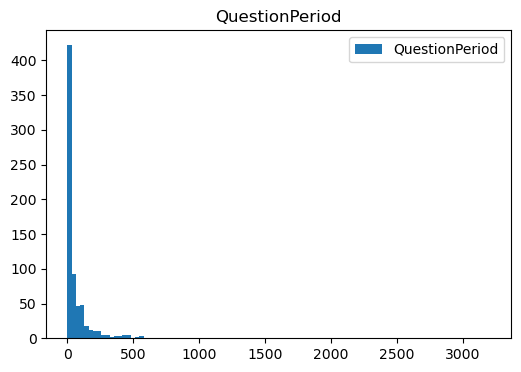

In [106]:
QuestionPeriod_hist = Results.hist(column = ["QuestionPeriod"], figsize = (6,4),legend = True, bins = 100, grid = False)
Results['QuestionPeriod'].max()


In [107]:
# for exploration of the data regarding the logistic regression, can be removed later.
zeroQuestion = Results[Results.QuestionPeriod == 0]
zeroQuestion
# Number of Rows, number of data points that asked 0 question 
zeroQuestion.shape[0] 
# since the '0' values is not a very much in comparison of the whole data size, so it will not affect our regression model.

22

As we could see from the histogram above,the distribution is left-skewed. And the maximum Question asked per period is $3208$, which is the number of question answered by Justin Trudeau. We decide to delete this maximum column and convert add a column for Log Questions. Therefore, we would have a close to normal data for regression analysis.  
// Editing needed. Question asked or Question answered?

In [108]:
# creating a log of the QuestionPeriod variable
Results['QuestionsLog'] = np.log10(Results['QuestionPeriod'])
# Drop the rows that the Log Quesitions has negative values. 
Results = Results.loc[Results['QuestionPeriod'] >= 1]
# Find the index of Justin Trudeau and confirm the index
Results['QuestionPeriod'].idxmax()
Results.loc[80]
# Drop the row of Justin Trudeau's data
Results = Results.drop([80])
# Reset the index
Results = Results.reset_index()
Results
# Data Size = 672

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,index,Name,Parliament,Politician ID,Riding ID,Province,QuestionPeriod,PvtMemBills,Statements,Backbencher,AgeOnElectionDay,YearsInHOC,Gender,RanForNE,Reelected,ConservativeMem,LiberalMem,NDPMem,QuestionsLog
0,0,Dean Allison,42,5,35068,ON,42,0,19,0,54.0,15.323288,0,1,1,1,0,0,1.623249
1,1,Rona Ambrose,42,6,48033,AB,457,1,3,0,50.0,15.323288,1,0,0,1,0,0,2.659916
2,2,David Anderson,42,9,47002,SK,53,1,20,0,62.0,18.909589,0,0,0,1,0,0,1.724276
3,3,Charlie Angus,42,11,35107,ON,168,0,15,1,56.0,15.323288,0,1,1,0,0,1,2.225309
4,4,Larry Bagnell,42,15,60001,YT,11,1,15,1,69.0,16.350685,0,1,1,0,1,0,1.041393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668,691,Maninder Sidhu,43,12210,35009,ON,5,0,3,1,37.0,1.917808,0,1,1,0,1,0,0.698970
669,692,Nelly Shin,43,12222,59023,BC,13,0,6,0,50.0,1.917808,1,1,0,1,0,0,1.113943
670,693,Rob Morrison,43,12228,59015,BC,10,0,4,0,65.0,1.917808,0,1,1,1,0,0,1.000000
671,694,Marci Ien,43,12231,35108,ON,4,0,2,1,52.0,0.901370,1,1,1,0,1,0,0.602060


##### Histogram for Log Questions Asked per period

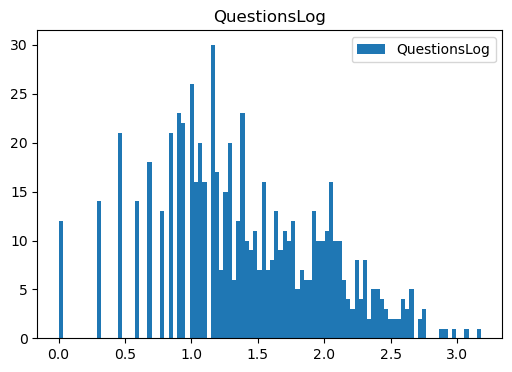

In [109]:
LogQuestionPeriod_hist = Results.hist(column = ["QuestionsLog"], figsize = (6,4),legend = True, bins = 100, grid = False)

Now just summarize the data - where we are at so far basically

##### VISUALIZATION: VARIABLES

##### *Reelection*

##### VISUALIZATION: RELATIONSHIPS

##### *Questions and Gender*

In [110]:
# Ridings = gpd.read_file('FED_CA_2021_EN.shp')

In [111]:
# fig, ax = plt.subplots(1, 1, figsize=(15, 15))
# Ridings.plot(ax=ax)

#### Regression Model
We use the logistic regression model to predict the results of re-elected or not. Also, we will compare how different regressors affect the prediction accuracy for our model. 

In [112]:
# checking for NaN values in the dataframe
Results.isnull().sum()
Results.AgeOnElectionDay.isnull().sum()
Results.AgeOnElectionDay.mean()

53.04791344667697

Since we have missing values in the AgeOnElectionDay column, we would impute the missing values with the mean AgeOnElectionDay for the analysis.

In [113]:
# impute the missing AgeOnElectionDay values with mean
Results['AgeOnElectionDay'].fillna((Results['AgeOnElectionDay'].mean()), inplace=True)
# check the dataframe for missing value again
Results.AgeOnElectionDay.isnull().sum()

0

#### Trainning Set and Testing Set

Since the length of data for 2015 have 4 year and the length for 2019 only has 2 years. So we use 2015 data as 

In [114]:
# Data seperation ratio exloration
# 1. comparison of 2015 and 2019 data for QuestionPeriod, affected by data year length.

QuestionPeriod_2015 = Results.QuestionPeriod[Results.Parliament == 42]
QuestionPeriod_2015
QuestionPeriod_2019 = Results.QuestionPeriod[Results.Parliament == 43]
QuestionPeriod_2019
print(QuestionPeriod_2015.mean())
print(QuestionPeriod_2019.mean())


96.06927710843374
38.84457478005865


Since mean for 2015 QuestionPeriod data and 2019 data has dramatic difference, we could conclude that the length of data would affect our analysis. 4 year data has more number of QuestionPeriod than 2 year data. Therefore, we should not choose the 2015 data as training set and 2019 data as test set.

In [115]:
# 2. Trainning Set = 80% of 2015 data + 80% of 2019 data, Testing Set = 20% of 2015 data + 20% of 2019 data


# 3. Randomly Select 80% of data among 2015 and 2019 data set as Trainning Set, 20% as Testing Set.
train= Results.sample(frac = 0.8, random_state = 123)
test= Results.drop(train.index)
# Check if the sample size match after splitting
print(train.shape[0] + test.shape[0] == Results.shape[0])

True


In [116]:
Results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 673 entries, 0 to 672
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             673 non-null    int64  
 1   Name              673 non-null    object 
 2   Parliament        673 non-null    int64  
 3   Politician ID     673 non-null    int64  
 4   Riding ID         673 non-null    int64  
 5   Province          673 non-null    object 
 6   QuestionPeriod    673 non-null    int64  
 7   PvtMemBills       673 non-null    int64  
 8   Statements        673 non-null    int64  
 9   Backbencher       673 non-null    int64  
 10  AgeOnElectionDay  673 non-null    float64
 11  YearsInHOC        673 non-null    float64
 12  Gender            673 non-null    uint8  
 13  RanForNE          673 non-null    uint8  
 14  Reelected         673 non-null    uint8  
 15  ConservativeMem   673 non-null    uint8  
 16  LiberalMem        673 non-null    uint8  
 1

In [117]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('Reelected',axis=1), 
                                                    train['Reelected'], test_size=0.20, 
                                                    random_state=123)

##### Model 1
Regressors: Question Asked (Log), Private Number Bills Proposed,  Statements Made.

In [118]:
# Prep Model 1 df
# use QuestionPeriod or QuestionLog
train_model_1 = train[['QuestionPeriod','PvtMemBills','Statements','Reelected']]
train_model_1
test_model_1 = test[['QuestionPeriod','PvtMemBills','Statements','Reelected']]
test_model_1

,QuestionPeriod,PvtMemBills,Statements,Reelected
2,53,1,20,0
3,168,0,15,1
8,225,2,36,1
14,16,0,9,0
16,75,0,19,0
...,...,...,...,...
644,16,0,6,0
653,8,1,5,0
665,12,0,10,1
669,13,0,6,0


In [119]:
X_train_model_1, X_test_model_1, y_train_model_1, y_test_model_1 = train_test_split(train_model_1.drop('Reelected',axis=1), 
                                                    train_model_1['Reelected'], test_size=0.20, 
                                                    random_state=123)

In [120]:
logmodel_1 = LogisticRegression()
logmodel_1.fit(X_train_model_1,y_train_model_1)
predictions_model_1 = logmodel_1.predict(X_test_model_1)
print(classification_report(y_test_model_1,predictions_model_1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.71      0.99      0.83        77

    accuracy                           0.70       108
   macro avg       0.36      0.49      0.41       108
weighted avg       0.51      0.70      0.59       108



In [121]:
# above table already has the accuracy score, 0.70
score_model_1 = accuracy_score(y_test_model_1,predictions_model_1)
score_model_1

0.7037037037037037

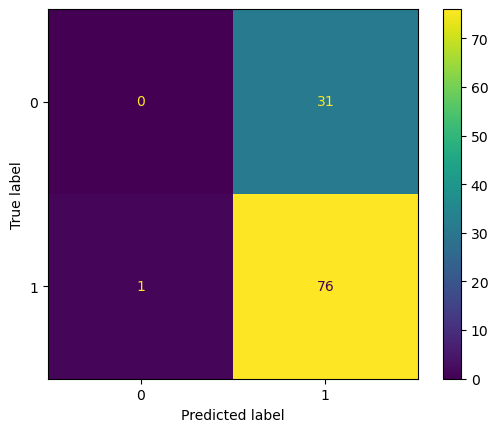

In [122]:
ConfusionMatrixDisplay.from_predictions(y_test_model_1, predictions_model_1)

##### Model 2
Regressors: Question Asked (Log), Private Number Bills Proposed,  Statements Made, Gender, Age.

In [123]:
# Prep Model 2 df
# use QuestionPeriod or QuestionLog
train_model_2 = train[['QuestionPeriod','PvtMemBills','Statements','Reelected','AgeOnElectionDay','Gender']]
train_model_2
test_model_2 = test[['QuestionPeriod','PvtMemBills','Statements','Reelected','AgeOnElectionDay','Gender']]
test_model_2

,QuestionPeriod,PvtMemBills,Statements,Reelected,AgeOnElectionDay,Gender
2,53,1,20,0,62.0,0
3,168,0,15,1,56.0,0
8,225,2,36,1,54.0,0
14,16,0,9,0,65.0,0
16,75,0,19,0,63.0,0
...,...,...,...,...,...,...
644,16,0,6,0,46.0,1
653,8,1,5,0,27.0,1
665,12,0,10,1,53.0,1
669,13,0,6,0,50.0,1


In [124]:
X_train_model_2, X_test_model_2, y_train_model_2, y_test_model_2 = train_test_split(train_model_2.drop('Reelected',axis=1), 
                                                    train_model_2['Reelected'], test_size=0.20, 
                                                    random_state=123)

In [125]:
logmodel_2 = LogisticRegression()
logmodel_2.fit(X_train_model_2,y_train_model_2)
predictions_model_2 = logmodel_2.predict(X_test_model_2)
print(classification_report(y_test_model_2,predictions_model_2))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.71      0.99      0.83        77

    accuracy                           0.70       108
   macro avg       0.36      0.49      0.41       108
weighted avg       0.51      0.70      0.59       108



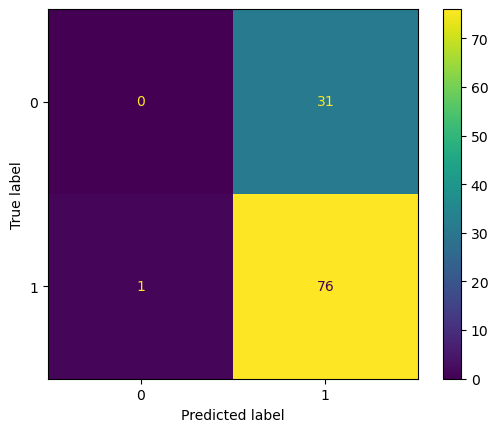

In [126]:
ConfusionMatrixDisplay.from_predictions(y_test_model_2, predictions_model_2)

#### Model 3
Regressors: Question Asked (Log), Private Number Bills Proposed, Statements Made, Gender, Age, Years in House of Commons, Conservative Member, Liberal Member, NDP Member, Backbencher.

In [131]:
# Prep Model 3 df
# use QuestionPeriod or QuestionLog
#!!!! Having problem with adding Backbencher, datatype is int, not uint8
# !!!!!!
train_model_3 = train[['QuestionPeriod','PvtMemBills','Statements','Reelected','AgeOnElectionDay','Gender','YearsInHOC','ConservativeMem','LiberalMem','NDPMem']]
train_model_3
test_model_3 = test[['QuestionPeriod','PvtMemBills','Statements','Reelected','AgeOnElectionDay','Gender','YearsInHOC','ConservativeMem','LiberalMem','NDPMem']]
test_model_3

,QuestionPeriod,PvtMemBills,Statements,Reelected,AgeOnElectionDay,Gender,YearsInHOC,ConservativeMem,LiberalMem,NDPMem
2,53,1,20,0,62.0,0,18.909589,1,0,0
3,168,0,15,1,56.0,0,15.323288,0,0,1
8,225,2,36,1,54.0,0,15.323288,1,0,0
14,16,0,9,0,65.0,0,15.323288,0,0,1
16,75,0,19,0,63.0,0,18.909589,0,1,0
...,...,...,...,...,...,...,...,...,...,...
644,16,0,6,0,46.0,1,1.917808,0,1,0
653,8,1,5,0,27.0,1,1.917808,0,0,1
665,12,0,10,1,53.0,1,1.917808,0,1,0
669,13,0,6,0,50.0,1,1.917808,1,0,0


In [128]:
Results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 673 entries, 0 to 672
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             673 non-null    int64  
 1   Name              673 non-null    object 
 2   Parliament        673 non-null    int64  
 3   Politician ID     673 non-null    int64  
 4   Riding ID         673 non-null    int64  
 5   Province          673 non-null    object 
 6   QuestionPeriod    673 non-null    int64  
 7   PvtMemBills       673 non-null    int64  
 8   Statements        673 non-null    int64  
 9   Backbencher       673 non-null    int64  
 10  AgeOnElectionDay  673 non-null    float64
 11  YearsInHOC        673 non-null    float64
 12  Gender            673 non-null    uint8  
 13  RanForNE          673 non-null    uint8  
 14  Reelected         673 non-null    uint8  
 15  ConservativeMem   673 non-null    uint8  
 16  LiberalMem        673 non-null    uint8  
 1

In [132]:
X_train_model_3, X_test_model_3, y_train_model_3, y_test_model_3 = train_test_split(train_model_3.drop('Reelected',axis=1), 
                                                    train_model_3['Reelected'], test_size=0.20, 
                                                    random_state=123)

In [133]:
logmodel_3 = LogisticRegression()
logmodel_3.fit(X_train_model_3,y_train_model_3)
predictions_model_3 = logmodel_3.predict(X_test_model_3)
print(classification_report(y_test_model_3,predictions_model_3))

              precision    recall  f1-score   support

           0       0.20      0.03      0.06        31
           1       0.71      0.95      0.81        77

    accuracy                           0.69       108
   macro avg       0.45      0.49      0.43       108
weighted avg       0.56      0.69      0.59       108



/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


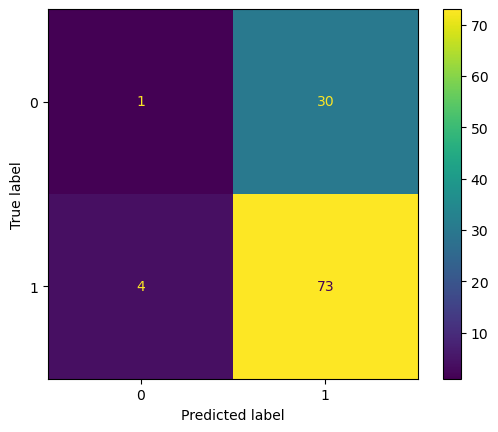

In [134]:
ConfusionMatrixDisplay.from_predictions(y_test_model_3, predictions_model_3)